In [1]:
from astropy.io import fits
import numpy as np
import pylab as plt
import sys
sys.path.append('/Users/pdh21/HELP/XID_plus/xidplus/')
import XIDp_mod_beta as xid_mod
import pickle
import dill
%matplotlib inline

/Users/pdh21/HELP/XID_plus/xidplus XIDp_mod_beta.pyc
/Users/pdh21/HELP/XID_plus/scripts/test_run


/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
infile='Lacy_test_file.pkl'
with open(infile, "rb") as f:
    obj = pickle.load(f)
prior250=obj['psw']
prior350=obj['pmw']    
prior500=obj['plw']

posterior=obj['posterior']

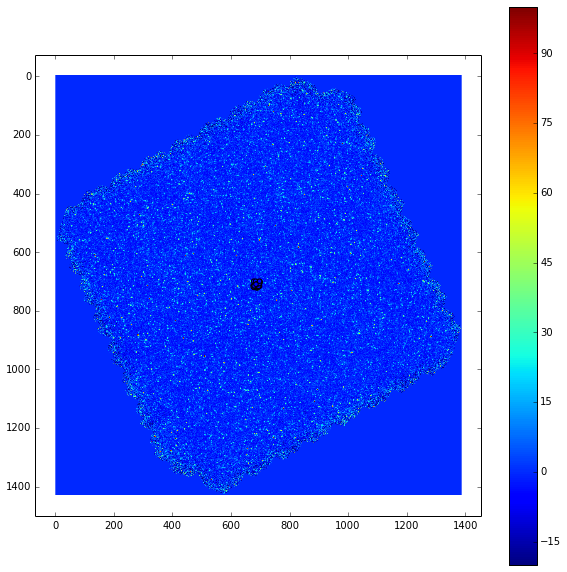

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(prior250.im, vmin=-20,vmax=100)
plt.colorbar()
plt.scatter(prior250.sx,prior250.sy)

In [13]:
print dir(posterior)
print posterior.stan_fit[:,0,-1]

['Rhat', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'convergence_stats', 'covariance_sparse', 'n_eff', 'nsrc', 'param_names', 'quantileGet', 'stan_fit']
[-498.4994677  -498.05351987 -501.53450522 -497.86028073 -497.41830384
 -508.50948739 -507.63136784 -518.66314968 -504.59883795 -508.12994691
 -516.62831898 -510.54571287 -493.17473915 -498.66951652 -495.21050397
 -494.50127033 -505.34197672 -511.6771379  -512.3013591  -509.45700021
 -505.05795949 -516.10006354 -516.22293574 -505.60009706 -516.65162367
 -521.24974187 -522.58805325 -520.03640934 -501.71790359 -492.08387135
 -492.73817458 -501.35904689 -525.05397398 -508.62689292 -496.09969883
 -504.8190505  -501.76257937 -503.85335167 -513.0352533  -509.5754143
 -502.37684508 -491.62129748 -502.28430593 -509.68742782 -509.8428969
 

In [14]:

#----output folder-----------------
output_folder='./'

#Folder containing prior input catalogue
folder='../../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'

hdulist = fits.open(folder+prior_cat)
fcat=hdulist[1].data
hdulist.close()
f_src=fcat['S100']#100 micron flux
f_psw=fcat['S250']
sgood=f_src >0.050

inra=fcat['RA'][sgood]
indec=fcat['DEC'][sgood]
f_src=f_src[sgood]
f_psw=f_psw[sgood]
sgood=(inra > prior250.tile[0,0]-prior250.buffer_size) & (inra < prior250.tile[0,2]+prior250.buffer_size) & (indec > prior250.tile[1,0]-prior250.buffer_size) & (indec < prior250.tile[1,2]+prior250.buffer_size)

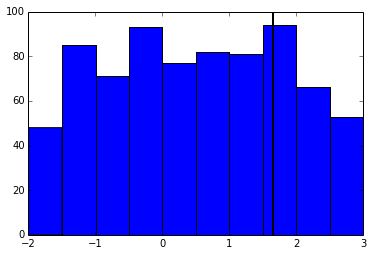

In [19]:
plt.hist(posterior.stan_fit[:,3,24])
plt.axvline(x=np.log10(f_psw[sgood][24]), linewidth=2, color='k')


In [ ]:
for i in range(0,prior250.nsrc):
    print i,f_psw[sgood][i]

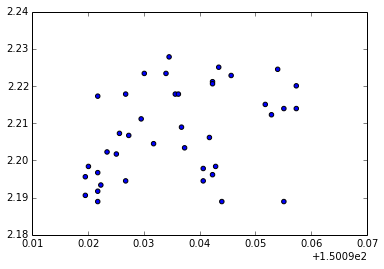

In [21]:
plt.scatter(prior250.sra,prior250.sdec)

In [22]:
cat=xid_mod.create_XIDp_SPIREcat_nocov(posterior,prior250,prior350,prior500)

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]
        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead.


In [25]:
print cat[1].data['flux250']

[ 0.39275295  0.47496298  0.46361962  0.54965138  0.50808662  0.47624096
  0.5241372   0.51367348  0.44890103  0.48551089  0.46194184  0.47699827
  0.53635412  0.44457045  0.48869047  0.48898715  0.45286161  0.48809898
  0.52967685  0.5883022   0.44576797  0.46916389  0.51955581 -0.82163155
  0.47929475  0.48791993  0.57315558  0.5196293   0.52991664  0.53970295
  0.48545933  0.44977358  0.44397497  0.48504943  0.49491251  0.42872179
  0.45865333  0.47456965  0.51822424 -1.08161628]


In [26]:
def yrep_map(prior,fvec):
    from scipy.sparse import coo_matrix
    

    x_range=np.max(prior.sx_pix)-np.min(prior.sx_pix)
    y_range=np.max(prior.sy_pix)-np.min(prior.sy_pix)
    f=coo_matrix((fvec, (range(0,prior.nsrc+1),np.zeros(prior.nsrc+1))), shape=(prior.nsrc+1, 1))
    A=coo_matrix((prior.amat_data, (prior.amat_row, prior.amat_col)), shape=(prior.snpix, prior.nsrc+1))
    rmap_temp=(A*f)
    pred_map=np.empty_like(prior.im)
    pred_map[:,:]=0.0#prior.im
    pred_map_noise=np.empty_like(prior.im)
    pred_map_noise[:,:]=0.0#prior.im
    pred_map[prior.sy_pix,prior.sx_pix]=np.asarray(rmap_temp.todense()).reshape(-1)#+np.random.randn(prior.snpix)*prior.snim
    pred_map_noise[prior.sy_pix,prior.sx_pix]=np.asarray(rmap_temp.todense()).reshape(-1)+np.random.randn(prior.snpix)*prior.snim

    return pred_map,pred_map_noise

In [30]:
fvec=np.power(10.0,posterior.stan_fit[0,0,0:41])
fvec[-1]=np.log10(fvec[-1])
rep_map=yrep_map(prior250,fvec)

<matplotlib.colorbar.Colorbar instance at 0x1134f3878>

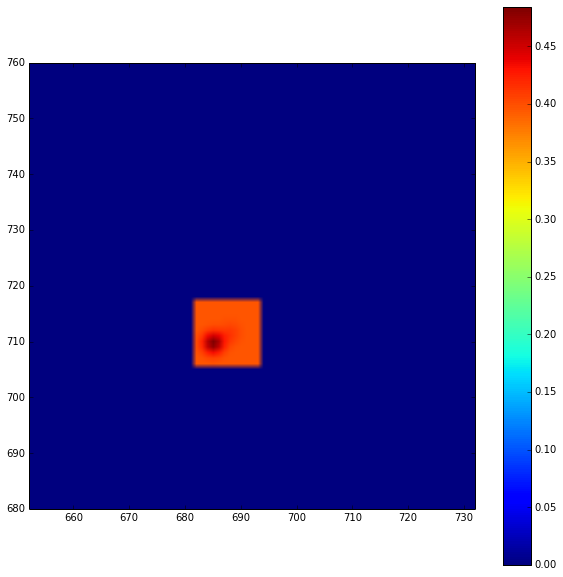

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(rep_map[0])
plt.xlim(prior250.sx[0]-40,prior250.sx[0]+40)
plt.ylim(prior250.sy[0]-40,prior250.sy[0]+40)

plt.colorbar()
#plt.scatter(prior250.sx,prior250.sy)

This is exploring the $250\_{\mathrm{\mu m}}$ map